<h1><center>LA311 2016 - 2021 Time Series Analysis & Daily Forecast</center></h1>

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

from pylab import rcParams

from statsmodels.tsa.stattools import adfuller

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# The method below is taken from https://builtin.com/data-science/time-series-forecasting-python

<h2>Reading and Displaying the data</h2>

Read `2016_2021_original_count.csv` which includes the data from 2016 until 2016 in which only the colums CreatedDate and RequestType were chosen.

In [3]:
df = pd.read_csv("2016_2021_original_count.csv")
df.head()

CreatedDate                 RequestType
0  01/01/2016 08:12:00 AM      Illegal Dumping Pickup
1  01/01/2016 08:15:00 AM         Dead Animal Removal
2  01/01/2016 08:26:00 AM         Dead Animal Removal
3  01/01/2016 08:28:00 AM                 Bulky Items
4  01/01/2016 08:29:00 AM  Metal/Household Appliances

In [4]:
df.shape

(7545336, 2)

In [5]:
# Create a copy of df and call it df1
df1 = df.copy()

# convert the CreateDate column into a datetime object. This will allow it to programmatically
# pull time values like the year or month for each record.
df1['CreatedDate'] = pd.to_datetime(df1['CreatedDate'])

In [6]:
# Set the index of df1
df1.index = df1['CreatedDate']

# Group the CreateDate by day and count the number of request count per day
df1 = pd.DataFrame(df1.groupby(pd.Grouper(freq='D')).size())

In [7]:
# Rename the index and column
df1.index.name = 'Date'
df1.columns = ['RequestCount']

#df1.to_csv('2016_2021_daily_count.csv', index = True)
df1.head()

RequestCount
Date                    
2016-01-01           171
2016-01-02           480
2016-01-03           355
2016-01-04          3066
2016-01-05          2014

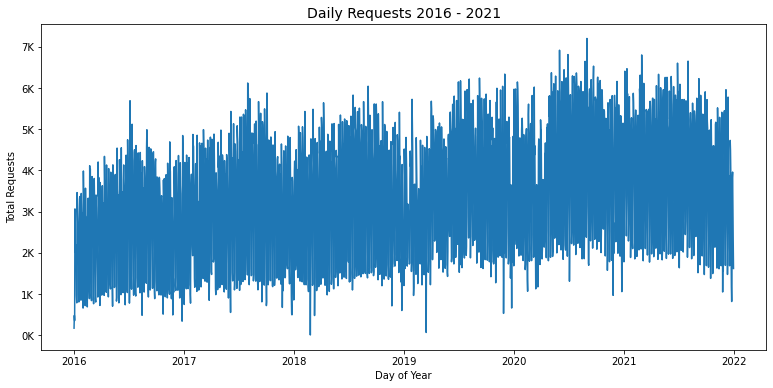

In [8]:
# Plot the daily requests number

fig, ax = plt.subplots(figsize=(13, 6))  
plt.plot(df1)
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.title('Daily Requests 2016 - 2021',fontsize=14)
plt.xlabel('Day of Year')
plt.ylabel('Total Requests')
plt.show()

The overall requests by day look pretty stationary and give an indication that the Prophet model might be a good fit for forecasting requests number. 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. __It works best with time series that have strong seasonal effects and several seasons of historical data.__ 

In [9]:
df1.describe()

RequestCount
count   2192.000000
mean    3442.215328
std     1516.586485
min        6.000000
25%     2111.500000
50%     3481.000000
75%     4699.250000
max     7203.000000

Note that there are 2192 days since there are two years between 2016 - 2021 which have 366 days in a year. 

In [10]:
# Count the requests number per week

df_week = df1.reset_index()
order = ['Sunday', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df_week2 = df_week.groupby(df_week['Date'].dt.day_name()).sum().reindex(order)
df_week2

RequestCount
Date                   
Sunday           558163
Monday          1489839
Tuesday         1480834
Wednesday       1403253
Thursday        1190810
Friday           933076
Saturday         489361

In [11]:
df_week3 =  df1.reset_index()
df_week3.index = df_week3['Date']
df_week3['week_days'] =df_week3.index.day_name()
df_week3.head()

Date  RequestCount week_days
Date                                         
2016-01-01 2016-01-01           171    Friday
2016-01-02 2016-01-02           480  Saturday
2016-01-03 2016-01-03           355    Sunday
2016-01-04 2016-01-04          3066    Monday
2016-01-05 2016-01-05          2014   Tuesday

In [12]:
p = df_week3.pivot(index='Date', columns=['week_days'], values='RequestCount')
new_p = p[order]

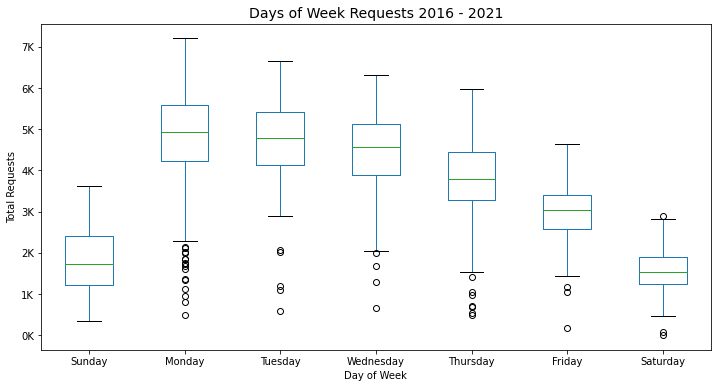

In [13]:
# Plot the days of week requests number boxplot

fig, ax = plt.subplots(figsize=(12, 6))  
new_p.boxplot()
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.title('Days of Week Requests 2016 - 2021',fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Total Requests')
plt.grid(b=None)

From the above boxplot, we see the requests number is very low on Saturday and Sunday, and it is very high on Monday, follow by Tuesday, Wednesday, Thurday, and Friday.

<h2>Forecasting</h2>

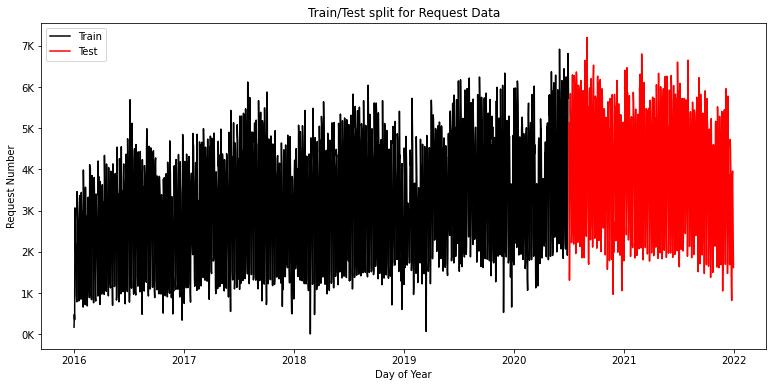

In [14]:
# We split the date into about 75% training and 25% (548) testing
df1['Date'] = df1.index
train = df1[df1['Date'] < pd.to_datetime("2020-7-2", format='%Y-%m')]
del train['Date']
test = df1[df1['Date'] >= pd.to_datetime("2020-7-2", format='%Y-%m')]
del test['Date']
fig, ax = plt.subplots(figsize=(13, 6))  
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.plot(train, color = "black", label="Train")
plt.plot(test, color = "red", label="Test")
plt.title("Train/Test split for Request Data")
plt.ylabel("Request Number")
plt.xlabel('Day of Year')
plt.legend(loc='upper left')
plt.show()

In [15]:
from fbprophet import Prophet

In [16]:
# Rename the train and test columns as ds and y. This is required by Prophet.
train = train.reset_index()
test = test.reset_index()
train = train.rename(columns={'Date': 'ds', 'RequestCount': 'y'})
test = test.rename(columns={'Date': 'ds', 'RequestCount': 'y'})
train.head()

ds     y
0 2016-01-01   171
1 2016-01-02   480
2 2016-01-03   355
3 2016-01-04  3066
4 2016-01-05  2014

In [17]:
# Fit prophet model on the requests number dataset
# set the uncertainty interval to 95% (the Prophet default is 80%)
m = Prophet(interval_width=0.95)
m.fit(train)
future = m.make_future_dataframe(periods=548, freq="d") # 25% of 2192
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
forecast

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2016-01-01  2388.947522   288.106738  2693.205049  2388.947522   
1    2016-01-02  2390.308253 -1219.307196  1158.542613  2390.308253   
2    2016-01-03  2391.668984 -1053.834360  1365.818068  2391.668984   
3    2016-01-04  2393.029715  1961.443440  4290.264789  2393.029715   
4    2016-01-05  2394.390446  1892.091151  4392.102774  2394.390446   
5    2016-01-06  2395.751177  1799.404190  4113.965938  2395.751177   
6    2016-01-07  2397.111908  1201.619772  3592.562735  2397.111908   
7    2016-01-08  2398.472638   563.471063  3007.500588  2398.472638   
8    2016-01-09  2399.833369  -886.671002  1526.070142  2399.833369   
9    2016-01-10  2401.194100  -718.251550  1655.728590  2401.194100   
10   2016-01-11  2402.554831  2312.781546  4679.217479  2402.554831   
11   2016-01-12  2403.915562  2316.001790  4654.810498  2403.915562   
12   2016-01-13  2405.276293  2162.612235  4529.924535  2405.276293   
13   2016-01-14  2406.637024  1452.277728  3900.028416  2406.637024   
14   2016-01-15  2407.997755   892.717539  3362.563299  2407.997755   
15   2016-01-16  2409.358485  -561.736073  1811.475967  2409.358485   
16   2016-01-17  2410.719216  -512.265916  1950.276465  2410.719216   
17   2016-01-18  2412.079947  2542.005738  4913.879993  2412.079947   
18   2016-01-19  2413.440678  2611.592596  4952.282690  2413.440678   
19   2016-01-20  2414.801409  2304.853311  4684.587864  2414.801409   
20   2016-01-21  2416.162140  1657.506709  4107.848615  2416.162140   
21   2016-01-22  2417.522871   996.084579  3319.413723  2417.522871   
22   2016-01-23  2418.883602  -478.551396  1992.814714  2418.883602   
23   2016-01-24  2420.244332  -406.326752  1958.384777  2420.244332   
24   2016-01-25  2421.605063  2621.850188  4881.644023  2421.605063   
25   2016-01-26  2422.965794  2466.391178  4870.951303  2422.965794   
26   2016-01-27  2424.326525  2243.378948  4665.687513  2424.326525   
27   2016-01-28  2425.687256  1496.928143  4051.006877  2425.687256   
28   2016-01-29  2427.047987   888.724729  3230.821550  2427.047987   
29   2016-01-30  2428.408718  -622.629987  1760.440614  2428.408718   
30   2016-01-31  2429.769449  -631.580637  1781.708959  2429.769449   
31   2016-02-01  2431.130179  2347.709572  4770.262593  2431.130179   
32   2016-02-02  2432.490910  2279.086650  4646.614669  2432.490910   
33   2016-02-03  2433.851641  2046.107887  4437.778232  2433.851641   
34   2016-02-04  2435.212372  1330.849401  3716.062590  2435.212372   
35   2016-02-05  2436.573103   661.471101  2920.975219  2436.573103   
36   2016-02-06  2437.933834  -895.055537  1599.036247  2437.933834   
37   2016-02-07  2439.294565  -779.724120  1531.112903  2439.294565   
38   2016-02-08  2440.655296  2247.159022  4587.791029  2440.655296   
39   2016-02-09  2442.016026  2145.822306  4546.218908  2442.016026   
40   2016-02-10  2443.376757  1895.134677  4272.163272  2443.376757   
41   2016-02-11  2444.737488  1242.444180  3696.291810  2444.737488   
42   2016-02-12  2446.098219   516.653977  2932.505555  2446.098219   
43   2016-02-13  2447.458950  -843.946932  1448.632523  2447.458950   
44   2016-02-14  2448.819681  -779.058549  1676.850542  2448.819681   
45   2016-02-15  2450.180412  2204.815595  4664.506987  2450.180412   
46   2016-02-16  2451.541143  2276.692332  4591.643352  2451.541143   
47   2016-02-17  2452.901873  1978.706481  4298.693198  2452.901873   
48   2016-02-18  2454.262604  1348.685224  3765.913679  2454.262604   
49   2016-02-19  2455.623335   661.702290  3076.644305  2455.623335   
50   2016-02-20  2456.984066  -707.782401  1704.093541  2456.984066   
51   2016-02-21  2458.344797  -629.452155  1799.408799  2458.344797   
52   2016-02-22  2459.705528  2377.393573  4766.068520  2459.705528   
53   2016-02-23  2461.066259  2365.926107  4660.882310  2461.066259   
54   2016-02-24  2462.426989  2138.586758  4479.956964  2462.426989   
55   2016-02-25  2463.787720  1386.24

Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting. These are:

* __ds__: the datestamp of the forecasted value
* __yhat__: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
* __yhat_lower__: the lower bound of our forecasts
* __yhat_upper__: the upper bound of our forecasts

Note that:
* A variation in values from the output presented is to be expected as Prophet relies on __Markov chain Monte Carlo (MCMC)__ methods to generate its forecasts.

* MCMC is a stochastic process, so values will be slightly different each time.

The next step would be to visualize the training set to see the fit of the model. The blue line is the forecasted values while the black dots are the actual values. We can see that the blue line fits the overall trend of the data with some outliers still remaining.

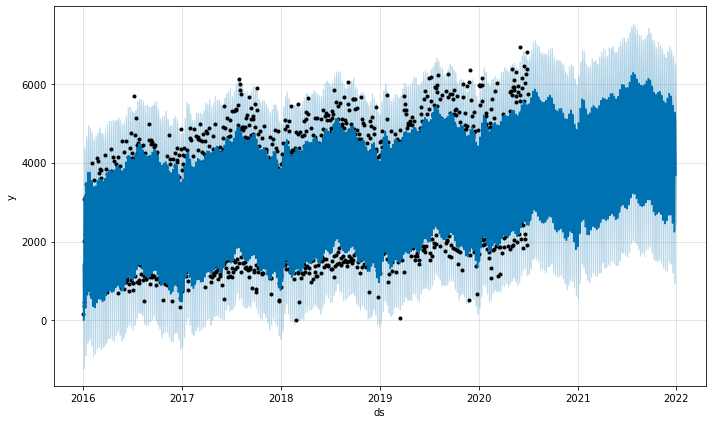

In [19]:
fig1 = m.plot(forecast, uncertainty=True)

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

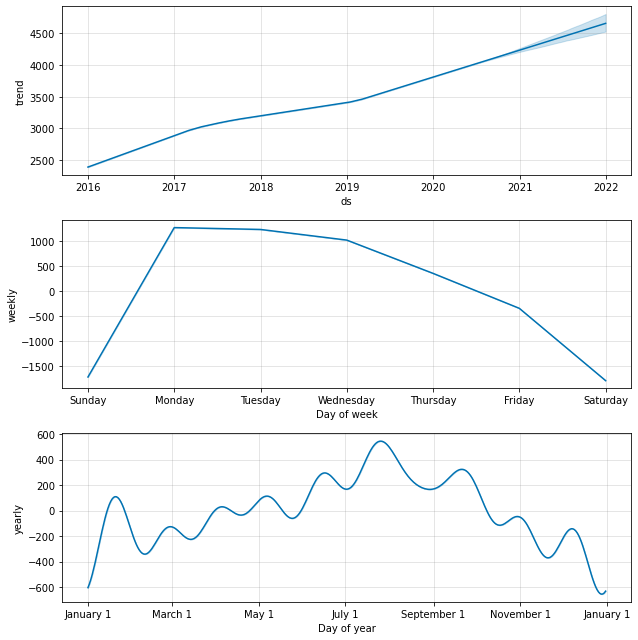

In [20]:
m.plot_components(forecast);

The above plot provides interesting insights:
* The first plot shows that the daily requests has been linearly increasing over time.
* The second plot highlights the fact that the weekly count of requests peaks towards the beginning of the week.
* The third plot shows that the most requests occurs during the holiday months of July and August.

In [21]:
del df1['Date']

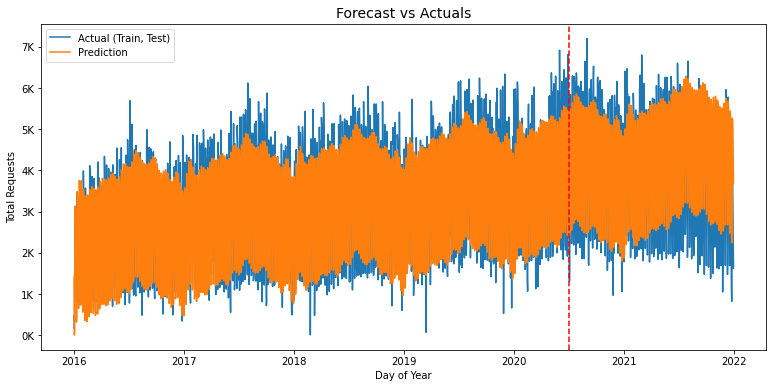

In [22]:
# Plot of the actuls vs forecast
fig, ax = plt.subplots(figsize=(13, 6))  
plt.plot(df1, label = 'Actual (Train, Test)')
plt.plot(forecast['ds'], forecast['yhat'], label ='Prediction')
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.title('Forecast vs Actuals',fontsize=14)
plt.xlabel('Day of Year')
plt.ylabel('Total Requests')
plt.legend(loc='upper left')
ax.axvline(pd.to_datetime('2020-07-02'), color='r', linestyle='--', lw=1.5)
plt.show()

In [23]:
prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [24]:
pred_21 = prediction.loc[(prediction.ds >= pd.to_datetime('2020-07-02'))]

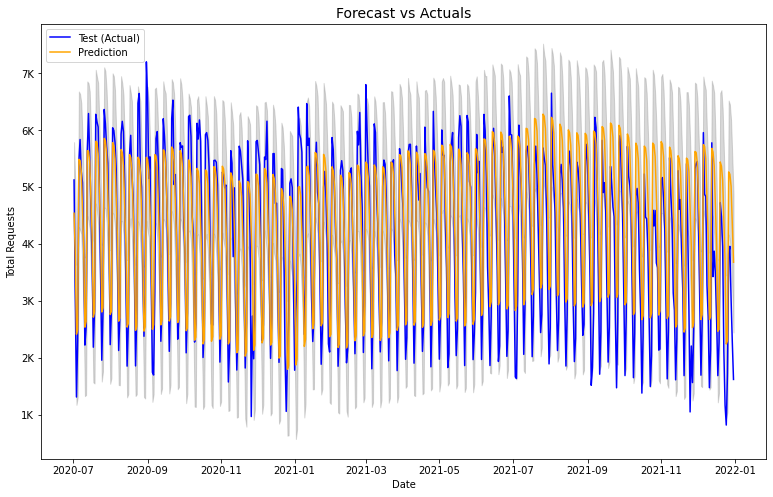

In [25]:
# Zoom-in of the testing and the forecast
fig, ax = plt.subplots(figsize=(13, 8))  
plt.plot(test['ds'], test['y'], color = "blue", label="Test (Actual)")
plt.plot(pred_21['ds'], pred_21['yhat'], label = "Prediction", color = 'orange')
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.title('Forecast vs Actuals',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.legend(loc='upper left')
ax.fill_between(pred_21['ds'], pred_21['yhat_lower'], pred_21['yhat_upper'], color='grey',alpha=.3)
plt.show()

From the above plot, we see that the predicion (orange) and the actuals (blue) does not align properly after early 2021. This is because __the model assumes that the trend of the requests number will steadily increase each day while we know that the actual number of requests is decreasing since early 2021__. See `LA311 2016 - 2021 Time Series Analysis & Monthly Forecast` seasonal_decompose.

In [26]:
test_prediction = test.merge(prediction, on=['ds'], how='left')
test_prediction['residual'] = test_prediction['y'] - test_prediction['yhat']
test_prediction

ds     y         yhat   yhat_lower   yhat_upper     residual
0   2020-07-02  5127  4541.781878  3363.011146  5791.140226   585.218122
1   2020-07-03  3124  3848.559291  2698.449413  5081.625813  -724.559291
2   2020-07-04  1311  2414.115624  1172.954232  3638.865019 -1103.115624
3   2020-07-05  2300  2496.027489  1299.358069  3684.338403  -196.027489
4   2020-07-06  5450  5488.782971  4295.845345  6682.160444   -38.782971
5   2020-07-07  5838  5467.580625  4247.798334  6640.472654   370.419375
6   2020-07-08  5275  5273.626261  4175.572631  6480.324572     1.373739
7   2020-07-09  5082  4630.938240  3489.459842  5907.447538   451.061760
8   2020-07-10  3930  3956.437250  2751.346514  5121.644762   -26.437250
9   2020-07-11  2224  2539.249136  1326.295969  3765.957738  -315.249136
10  2020-07-12  2526  2636.521773  1347.361247  3851.904786  -110.521773
11  2020-07-13  5655  5642.366735  4492.816073  6859.833776    12.633265
12  2020-07-14  6295  5631.667125  4418.810767  6827.774678   663.332875
13  2020-07-15  5533  5445.381395  4257.238645  6683.646531    87.618605
14  2020-07-16  4672  4807.353678  3565.199525  6028.476105  -135.353678
15  2020-07-17  3755  4134.406528  2954.263701  5347.275223  -379.406528
16  2020-07-18  2187  2715.644594  1569.674194  4081.503933  -528.644594
17  2020-07-19  2840  2808.270231  1548.744446  4009.224252    31.729769
18  2020-07-20  6281  5806.521889  4711.093720  7063.086121   474.478111
19  2020-07-21  6151  5785.476784  4587.151133  6940.729346   365.523216
20  2020-07-22  6059  5586.347862  4332.768243  6830.673079   472.652138
21  2020-07-23  4980  4933.285833  3708.667615  6121.046825    46.714167
22  2020-07-24  3467  4243.462411  3079.874585  5342.743287  -776.462411
23  2020-07-25  1958  2806.363632  1582.849503  3987.871903  -848.363632
24  2020-07-26  2807  2879.594526  1759.395871  4036.800927   -72.594526
25  2020-07-27  6366  5857.806358  4644.456169  7107.386148   508.193642
26  2020-07-28  6119  5816.488242  4627.740362  7041.556147   302.511758
27  2020-07-29  5715  5597.253472  4380.682705  6708.574286   117.746528
28  2020-07-30  5428  4924.631639  3751.064398  6109.151122   503.368361
29  2020-07-31  4145  4216.142947  2989.208765  5455.443250   -71.142947
30  2020-08-01  2232  2761.583823  1543.650364  3893.494425  -529.583823
31  2020-08-02  2825  2818.825299  1642.739487  3981.537221     6.174701
32  2020-08-03  6044  5782.735508  4548.841423  7001.296993   261.264492
33  2020-08-04  5996  5728.968202  4514.208764  6949.935769   267.031798
34  2020-08-05  5786  5499.247666  4278.008396  6701.024964   286.752334
35  2020-08-06  5309  4818.161079  3635.654931  5931.988716   490.838921
36  2020-08-07  3650  4103.234671  2948.731363  5334.710252  -453.234671
37  2020-08-08  2129  2644.222647  1522.929818  3903.541458  -515.222647
38  2020-08-09  2729  2698.910202  1516.669018  3808.220382    30.089798
39  2020-08-10  5933  5662.041767  4407.312121  6951.025167   270.958233
40  2020-08-11  6158  5609.116159  4397.875463  6828.129406   548.883841
41  2020-08-12  5976  5381.678761  4169.803200  6620.319161   594.321239
42  2020-08-13  5091  4704.121511  3443.920990  5829.762678   386.878489
43  2020-08-14  3316  3993.766787  2831.015891  5189.804826  -677.766787
44  2020-08-15  1854  2540.163872  1304.750533  3718.739597  -686.163872
45  2020-08-16  2578  2600.899083  1363.213061  3803.668758   -22.899083
46  2020-08-17  5576  5570.530464  4271.103142  6793.772383     5.469536
47  2020-08-18  5912  5524.388502  4452.122520  6670.369104   387.611498
48  2020-08-19  5218  5303.872834  4116.569199  6510.932982   -85.872834
49  2020-08-20  4848  4633.255579  3472.350240  5713.601476   214.744421
50  2020-08-21  3742  3929.767310  2688.666367  5148.688714  -187.767310
51  2020-08-22  1858  2482.894293  1328.643221  3636.202078  -624.894293
52  2020-08-23  2696  2550.188099  1357.985064  3826.863883   145.811901
53  2020-08-24  6477  5526.198535  4401.207498  6771.743668   950.8014

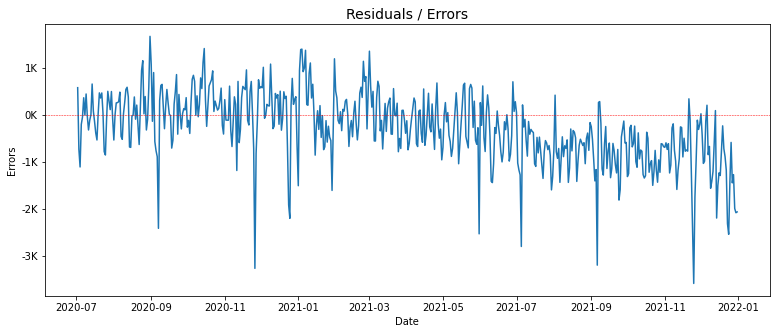

In [27]:
# Plot the residuals / errors
fig, ax = plt.subplots(figsize=(13, 5))  
plt.plot(test_prediction['ds'], test_prediction['residual'])
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.axhline(y=0, color='r', linestyle='--', lw = 0.5)
plt.title('Residuals / Errors',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Errors')
plt.show()

In [28]:
daily_range = []
for i in range(len(df1)-1):
    range_i = abs(df1['RequestCount'][i+1] - df1['RequestCount'][i])
    daily_range.append(range_i)
min(daily_range), max(daily_range)

(2, 5073)

In [29]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test_prediction['y'],test_prediction['yhat']))
print("RMSE: ", rmse)

RMSE:  788.9146873766381


Root Mean Square Error (RMSE) tells us that our model was capable of forecast the average daily total request in the test set within 788.91 of the actual total request. Our day to day total requests range from around 2 to over 5073. So, it seems the model is not that bad, but not good either.

<h3>Forecasting 2022</h3>

In [30]:
# Make an out-of-sample forecast. In this case year 2022
future2 = m.make_future_dataframe(periods=913, freq="d") #548 + 365 (2022)
forecast2 = m.predict(future2)

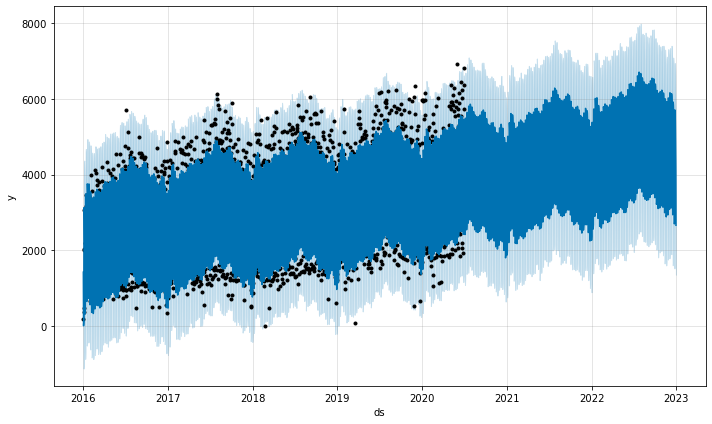

In [31]:
fig2 = m.plot(forecast2)

In [32]:
prediction2 = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prediction2

ds         yhat   yhat_lower   yhat_upper
0    2016-01-01  1419.999172   232.973247  2708.828474
1    2016-01-02     4.198916 -1127.322182  1101.624670
2    2016-01-03   107.754570 -1071.770783  1335.139423
3    2016-01-04  3124.712580  1869.905168  4339.015819
4    2016-01-05  3129.779694  1910.906187  4367.952678
5    2016-01-06  2963.629870  1805.604931  4153.115452
6    2016-01-07  2349.720662  1171.376243  3577.429939
7    2016-01-08  1704.394853   421.604019  2862.318291
8    2016-01-09   316.195631  -870.970797  1559.257517
9    2016-01-10   441.696023  -701.453832  1599.819375
10   2016-01-11  3474.453060  2156.987826  4607.896223
11   2016-01-12  3488.827751  2287.779752  4673.224525
12   2016-01-13  3325.300409  2197.155118  4596.859195
13   2016-01-14  2707.291590  1497.385612  3963.107533
14   2016-01-15  2051.264280   879.506552  3254.625501
15   2016-01-16   646.035638  -520.265767  1810.502869
16   2016-01-17   748.599081  -442.659444  2018.665658
17   2016-01-18  3753.067418  2472.239626  4937.499625
18   2016-01-19  3734.478381  2544.013318  4934.932666
19   2016-01-20  3534.092510  2372.408064  4657.211638
20   2016-01-21  2876.194099  1660.992862  4019.179775
21   2016-01-22  2178.171394   959.628123  3567.563772
22   2016-01-23   729.804920  -439.688555  1853.679700
23   2016-01-24   789.065355  -397.226522  1932.022915
24   2016-01-25  3751.032296  2568.787483  4872.672742
25   2016-01-26  3691.675899  2482.338659  4806.777257
26   2016-01-27  3453.131978  2268.908964  4658.279794
27   2016-01-28  2760.481878  1481.185797  3988.472469
28   2016-01-29  2031.813820   851.153035  3236.280892
29   2016-01-30   557.495110  -599.094834  1700.299714
30   2016-01-31   595.957009  -623.332946  1735.636025
31   2016-02-01  3542.603924  2331.205132  4771.617986
32   2016-02-02  3473.589147  2221.349072  4674.154623
33   2016-02-03  3231.087813  2089.156913  4408.703519
34   2016-02-04  2540.078432  1320.005057  3747.502945
35   2016-02-05  1818.409597   536.714007  2993.702598
36   2016-02-06   356.081080  -835.749907  1478.196576
37   2016-02-07   411.040828  -782.957616  1592.692029
38   2016-02-08  3378.109157  2110.370615  4578.938867
39   2016-02-09  3332.771926  2029.232042  4512.481957
40   2016-02-10  3116.472871  1956.782394  4299.431668
41   2016-02-11  2453.415892  1316.710404  3644.556412
42   2016-02-12  1760.653317   606.223337  2946.456938
43   2016-02-13   327.388759  -876.398622  1516.706451
44   2016-02-14   410.795476  -816.658691  1614.392868
45   2016-02-15  3404.960971  2258.481267  4556.309881
46   2016-02-16  3384.699029  2216.839907  4565.923414
47   2016-02-17  3190.858921  1994.219349  4436.514704
48   2016-02-18  2547.142095  1398.925903  3697.616445
49   2016-02-19  1870.202035   621.415921  3087.341097
50   2016-02-20   448.955616  -770.456087  1642.694484
51   2016-02-21   540.406687  -636.056701  1765.231405
52   2016-02-22  3538.592499  2444.719882  4747.393906
53   2016-02-23  3518.394208  2352.847664  4737.940899
54   2016-02-24  3320.841253  2135.099671  4584.478221
55   2016-02-25  2669.920124  1424.212381  3909.918923
56   2016-02-26  1982.663481   781.237152  3158.618689
57   2016-02-27   548.448288  -600.220755  1736.470268
58   2016-02-28   624.804118  -555.824764  1789.496895
59   2016-02-29  3606.342705  2432.648651  4673.504959
60   2016-03-01  3568.550494  2462.947317  4687.339206
61   2016-03-02  3353.074502  2214.929520  4544.739104
62   2016-03-03  2684.512562  1497.079207  3904.664825
63   2016-03-04  1980.484446   853.662592  3179.113242
64   2016-03-05   530.913024  -741.125571  1716.813092
65   2016-03-06   593.817111  -630.018509  1793.811212
66   2016-03-07  3564.227505  2351.148526  4713.586934
67   2016-03-08  3517.968316  2356.649884  4684.551436
68   2016-03-09  3296.934210  2090.098543  4511.669604
69   2016-03-10  2625.874843  1448.183072  3793.034185
70   2016-03-11  1922.463121   607.511624  3151.296806
71   2016-03-12   476.576476  -690.911112  1597.89318

In [33]:
pred2_22 = prediction2.loc[(prediction2.ds >= pd.to_datetime('2022-01-01'))]

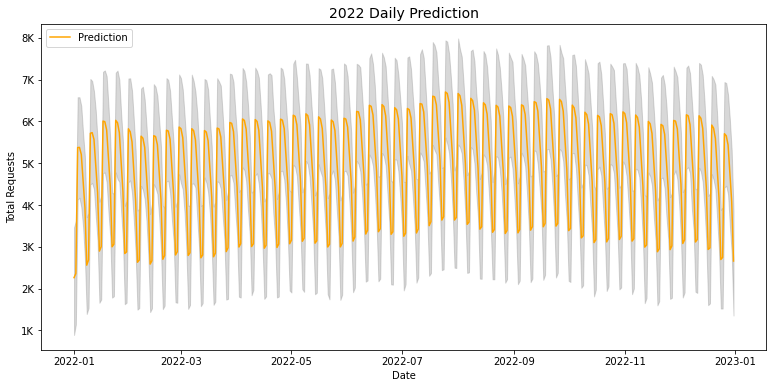

In [34]:
# Plot of 2022 Daily Prediction
fig, ax = plt.subplots(figsize=(13, 6))  
plt.plot(pred2_22['ds'], pred2_22['yhat'], color = 'orange', label = "Prediction" )
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.title('2022 Daily Prediction',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Requests')
ax.fill_between(pred2_22['ds'], pred2_22['yhat_lower'], pred2_22['yhat_upper'], color='grey',alpha=.3)
plt.legend(loc='upper left')
plt.show()

In [35]:
pred2_22['yhat'].describe()

count     365.000000
mean     4867.403787
std      1264.999896
min      2261.287970
25%      3479.217311
50%      5183.009484
75%      5976.755824
max      6705.188543
Name: yhat, dtype: float64

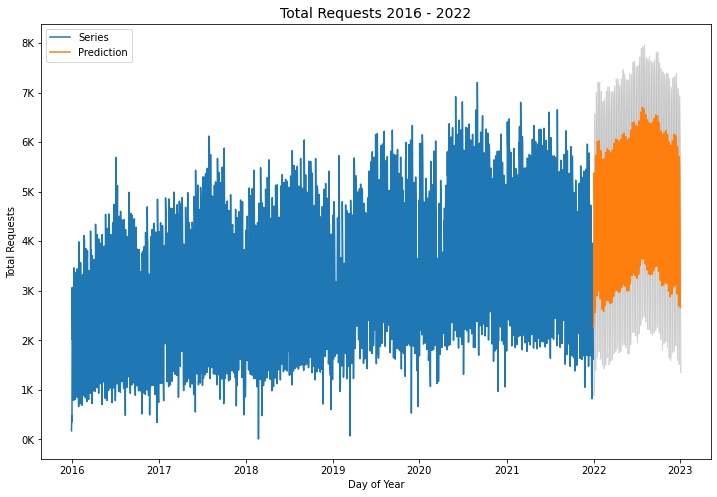

In [36]:
# Plot the predition together with the actual data

fig, ax = plt.subplots(figsize=(12, 8))  
f = lambda x, pos: f'{x/10**3:,.0f}K'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.plot(df1, label = "Series")
plt.plot(pred2_22['ds'], pred2_22['yhat'], label = "Prediction")
plt.title('Total Requests 2016 - 2022',fontsize=14)
plt.xlabel('Day of Year')
plt.ylabel('Total Requests')
plt.legend(loc='upper left')
ax.fill_between(pred2_22['ds'], pred2_22['yhat_lower'], pred2_22['yhat_upper'], color='grey',alpha=.3)
plt.show()

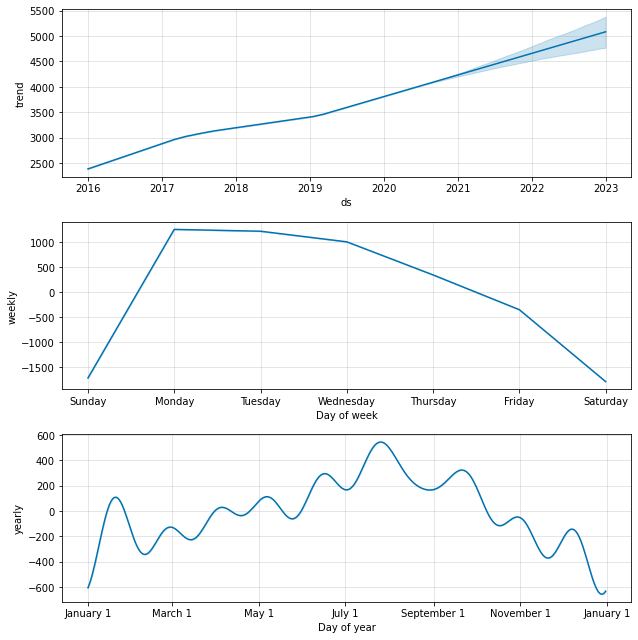

In [37]:
# See the components of our forecasts
m.plot_components(forecast2);

<h2>Summary</h2>

In this small project, we tried to make a daily prediction of 311 requests number using 2016-2021 311-data. We split the dataset into 75% training and 25% testing. We used Facebook Prophet to make the prediction. However, since the model assumed that the trend of the requests number would steadily increase, the gap (error) between the testing data and the prediction grew bigger after early 2021.  

To make a better predition of the requests number, probably we can try different time forecasting library instead of Facebook Prophet. Also, maybe we can add some features to make the model adapts to the decresing trend that we see since early 2021. 